In [1]:
import pandas as pd
import regex as re

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import ahocorasick

import torch
from transformers import T5ForConditionalGeneration, AutoTokenizer, MT5ForConditionalGeneration, get_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
#from fairseq.optim.adafactor import Adafactor

from tqdm import tqdm
import matplotlib.pyplot as plt

from copy import deepcopy

In [2]:
# CONSTANTS:

SEP_TOKEN = '▁<extra_id_0>'
INPUT_PREFIX = ''

NUM_OF_SPLITS = 40

ATTACHMENT_TOKEN = '▁<extra_id_1>'
LABEL_PREFIX_TOKEN = ATTACHMENT_TOKEN

USED_MODEL_NAME = 'cointegrated/rut5-small'

SEQ_MAX_LENGTH = 300
ANSWER_MAX_LENGTH = 170
BATCH_SIZE = 4
EVAL_BATCH_SIZE = 24

ENABLE_LABEL_FIX = True

LOCAL_NUM_EPOCHS = 2

In [3]:
tokenizer = AutoTokenizer.from_pretrained (USED_MODEL_NAME)

device = torch.device ('cuda' if torch.cuda.is_available () else 'cpu')
#device = torch.device ('cpu')

model = MT5ForConditionalGeneration.from_pretrained (USED_MODEL_NAME)

model.to (device)
print (model.device)

num_epochs = 50
#training_steps = len (train_data ['input_ids']) // BATCH_SIZE * num_epochs
#warmup_steps = int (training_steps * 0.1)
#print (f'Suggested train steps: {training_steps}\n\t warmup steps: {int (training_steps * 0.05)} - {int (training_steps * 0.1)}')

#optimizer = AdamW (model.parameters (), lr = 1e-5)#, weight_decay = 0.05)
optimizer = AdamW (filter (lambda p: p.requires_grad, model.parameters ()), lr = 1e-4, weight_decay = 0.01)
#optimizer = Adafactor (model.parameters (), lr = 3e-5, scale_parameter = False, relative_step = False, weight_decay = 0.02)
#scheduler = get_scheduler ('linear', optimizer = optimizer, num_warmup_steps = warmup_steps, num_training_steps = training_steps)

metrics = {'train_loss': [], 'val_loss': [], 'precision': [], 'recall': [], 'f1_score': []}

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
c:\Users\Enfi\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


cuda:0


In [4]:

# FUNCTIONS:

def split_text (text, segments, delimiters = ['...', '.', '?!', '?', '!']):

    delimiters_pattern = '|'.join (map (re.escape, delimiters))
    
    paragraphs = re.split (f'(?<=\n[ ]*)', text)
    
    sentences_with_segments = []
    
    current_start_index = 0

    for paragraph in paragraphs:

        sentences = re.split (f'(?<=[{delimiters_pattern}] )(?=[A-ZА-ЯЁ])', paragraph)#.strip ())

        for sentence in sentences:

            start_index = current_start_index
            end_index = start_index + len (sentence)

            matched_segments = [
                text [start: end] for start, end in segments if start >= start_index and end <= end_index
            ]
            sentences_with_segments.append ((sentence, matched_segments))

            current_start_index = end_index
    
    return sentences_with_segments

def create_parallels (data_lst, labels_lst):
    parallel_text = []
    parallel_label = []
    for i in range (len (data_lst)):
        text = data_lst [i]
        segments = labels_lst [i]
        splitted = split_text (text, segments)
        for sentence, terms in splitted:
            parallel_text.append (INPUT_PREFIX + sentence)
            constructed_label = LABEL_PREFIX_TOKEN
            for term in terms:
                constructed_label += SEP_TOKEN + term.strip ()
            parallel_label.append (constructed_label)
    return parallel_text, parallel_label


def label_constructor (labels):
    res = []
    for label in labels:
        one_label = []
        for start, end, cls in label:
            one_label.append ([start, end])
        res.append (one_label)
    return res


def one_finder (text, phrases):

    if len (phrases) == 1 and '' in phrases:
        return []

    A = ahocorasick.Automaton ()
    
    for idx, phrase in enumerate (phrases):
        A.add_word (phrase, (idx, phrase))
    
    A.make_automaton ()
    
    found = []
    for end_index, (idx, phrase) in A.iter (text):
        start_index = end_index - len (phrase) + 1

        if start_index > 0 and text [start_index - 1].isalpha ():
            continue
        if end_index + 1 < len (text) and text [end_index + 1].isalpha ():
            continue

        found.append ((start_index, end_index + 1, phrase))
    
    return found

def make_attachment (text, dictionary_terms):
    found = one_finder (text, dictionary_terms)
    found_terms = [item [2] for item in found]
    res = text + ATTACHMENT_TOKEN
    for term in found_terms:
        res += SEP_TOKEN + term
    return res

def attach_dictionary_foundings (texts, dictionary_terms):
    res_texts = []
    for text in tqdm (texts):
        res_texts.append (make_attachment (text, dictionary_terms))
    return res_texts

def replace_padding (labels):
    for i in range (0, len (labels ['input_ids'])):
        labels ['input_ids'] [i] = torch.tensor ([labl if labl != 0 else - 100 for labl in labels ['input_ids'] [i]])

    return labels

class Seq2SeqDataset (Dataset):
    def __init__ (self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__ (self, idx):
        return {
            'input_ids': self.encodings ['input_ids'] [idx],
            'attention_mask': self.encodings ['attention_mask'] [idx],
            'labels': self.labels ['input_ids'] [idx]
        }

    def __len__ (self):
        return len (self.encodings ['input_ids'])

def get_set (tensor, ground_truth = True, tokenizer = tokenizer):

    separator: str
    if SEP_TOKEN == '▁<extra_id_0>': separator = '<extra_id_0>'
    else: separator = SEP_TOKEN

    res: set

    if ground_truth:
        eos_idx = (tensor == 1).nonzero ()
        if eos_idx.numel () > 0:
            eos_idx = int (eos_idx [0] [0])
        else:
            eos_idx = len (tensor)
        seq = tensor [:eos_idx]
    
    else:
        seq = tensor [tensor != 0]
        seq = seq [seq != - 100]
        seq = seq [seq != 1]
    
    txt = tokenizer.decode (seq)
    res = set ([item.strip () for item in txt.split (separator)])

    if len (res) > 1:
        res -= set ([''])
    res -= set ([LABEL_PREFIX_TOKEN [1:]])
    if len (res) == 0: res |= set ([''])

    return res


def sanity_check (preds, labels, to_print = False):

    tps_sum = 0
    fps_sum = 0
    fns_sum = 0 

    for i in range (len (labels)):
        predicted_set = get_set (preds [i], ground_truth = False)
        true_set = get_set (labels [i])

        if to_print: print (f'True: {true_set}\nPred: {predicted_set}')

        tps_sum += len (true_set & predicted_set)  # Истинно положительные
        fps_sum += len (predicted_set - true_set)     # Ложноположительные
        fns_sum += len (true_set - predicted_set)     # Ложноотрицательные

    precision = tps_sum / (tps_sum + fps_sum) if (tps_sum + fps_sum) > 0 else 0
    recall = tps_sum / (tps_sum + fns_sum) if (tps_sum + fns_sum) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

In [5]:
df = pd.read_json ('train_t1_v1.jsonl', lines = True)
df.drop (columns = ['id', 'keywords'], inplace = True)
print (df.head ())
print ()
df_2 = pd.read_json ('./test_data/test1_t12_full_v2.jsonl', lines = True)
df_2 = df_2 [['text', 'label']]
print (df_2.head ())
print ()

val_data_txt, test_data_txt, val_labels_txt, test_labels_txt = train_test_split (df_2 ['text'], df_2 ['label'], test_size = 0.5, random_state = 14)

train_data_lst = df ['text'].tolist ()
train_labels_lst = df ['label'].tolist ()
train_parallel_text, train_parallel_labels = create_parallels (train_data_lst, train_labels_lst)

val_data_lst = val_data_txt.tolist ()
val_labels_lst = label_constructor (val_labels_txt)
val_parallel_text, val_parallel_labels = create_parallels (val_data_lst, val_labels_lst)

test_data_lst = test_data_txt.tolist ()
test_labels_lst = label_constructor (test_labels_txt)
test_parallel_text, test_parallel_labels = create_parallels (test_data_lst, test_labels_lst)

all_train_terms = set ()
for line in train_parallel_labels:
    all_train_terms |= set (line.split (SEP_TOKEN))
all_train_terms -= set ([''])
all_train_terms -= set ([LABEL_PREFIX_TOKEN])
print (f'Уникальных терминов во всём тренировочном наборе: {len (all_train_terms)}.\n')

val_parallel_text_new = attach_dictionary_foundings (val_parallel_text, all_train_terms)
test_parallel_text_new = attach_dictionary_foundings (test_parallel_text, all_train_terms)

val_data = tokenizer (val_parallel_text_new, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
val_labels = tokenizer (val_parallel_labels, padding = 'max_length', truncation = True, max_length = ANSWER_MAX_LENGTH, return_tensors = 'pt')

test_data = tokenizer (test_parallel_text_new, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
test_labels = tokenizer (test_parallel_labels, padding = 'max_length', truncation = True, max_length = ANSWER_MAX_LENGTH, return_tensors = 'pt')

if ENABLE_LABEL_FIX:
    
    replaced = replace_padding (val_labels)
    val_labels = replaced

    replaced = replace_padding (test_labels)
    test_labels = replaced

val_dataset = Seq2SeqDataset (val_data, val_labels)
test_dataset = Seq2SeqDataset (test_data, test_labels)

val_loader = DataLoader (val_dataset, batch_size = EVAL_BATCH_SIZE)
test_loader = DataLoader (test_dataset, batch_size = EVAL_BATCH_SIZE)

                                                text  \
0  ABBYY Retrieval & Morphology Engine\nВ сообщен...   
1  Речевые формулы в диалоге\nПредложенная класси...   
2  Географические названия и полнотекстовые докум...   
3  Методы автоматического построения специализиро...   
4  Закономерности построения дискурсивной последо...   

                                               label  
0  [[0, 35], [6, 15], [18, 35], [29, 35], [69, 88...  
1  [[0, 15], [18, 25], [74, 99], [134, 140], [175...  
2  [[0, 23], [26, 50], [54, 68], [169, 190], [181...  
3  [[7, 63], [34, 63], [54, 63], [92, 128], [119,...  
4  [[26, 57], [62, 76], [251, 265], [266, 280], [...  

                                                text  \
0  АВТОМАТИЧЕСКИЙ АНАЛИЗ ТОНАЛЬНОСТИ ТЕКСТОВ НА О...   
1  InBASE: ТЕХНОЛОГИЯ ПОСТРОЕНИЯ ЕЯ-ИНТЕРФЕЙСОВ К...   
2  Выражение уважительности с помощью личных мест...   
3  ДА ЧЕРТ ЛИ В ДЕТАЛЯХ?.. МЕРА ДЛЯ ОЦЕНКИ СОВПАД...   
4  КОРПУСНАЯ ОЦЕНКА СОЧЕТАЕМОСТИ СЛОВ С ИСПОЛЬЗОВ...

100%|██████████| 695/695 [00:08<00:00, 82.44it/s]


In [ ]:
kf = KFold (n_splits = NUM_OF_SPLITS)

data = df ['text']
labels = df ['label']

inc_term_set = set ([''])
for iteration, (train_index, test_index) in enumerate (kf.split (data)):
    X_curr = data [test_index]
    y_curr = labels [test_index]

    train_data_lst = X_curr.tolist ()
    train_labels_lst = y_curr.tolist ()
    parallel_text, parallel_labels = create_parallels (train_data_lst, train_labels_lst)

    parallel_text_new = attach_dictionary_foundings (parallel_text, inc_term_set)

    train_data = tokenizer (parallel_text_new, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
    train_labels = tokenizer (parallel_labels, padding = 'max_length', truncation = True, max_length = ANSWER_MAX_LENGTH, return_tensors = 'pt')
    
    if ENABLE_LABEL_FIX:
        replaced = replace_padding (train_labels)
        train_labels = replaced

    train_dataset = Seq2SeqDataset (train_data, train_labels)
    train_loader = DataLoader (train_dataset, batch_size = BATCH_SIZE, shuffle = True)

    for epoch in range (LOCAL_NUM_EPOCHS):
        model.train ()  # Устанавливаем модель в режим обучения
        total_loss = 0
        
        for batch in tqdm (train_loader):
            
            input_ids = batch ['input_ids'].to (model.device)
            attention_mask = batch ['attention_mask'].to (model.device)
            labels_fromdata = batch ['labels'].to (model.device)

            #outputs = model (input_ids = input_ids, attention_mask = attention_mask, labels = labels_fromdata)
            outputs = model (input_ids = input_ids, attention_mask = attention_mask, labels = labels_fromdata)
            loss = outputs.loss   ## DOUBLE CHECK if padding ...
            total_loss += loss.item ()

            loss.backward ()  # Обратное распространение
            optimizer.step ()  # Обновление параметров
            optimizer.zero_grad ()  # Обнуляем градиенты

            #scheduler.step ()  # Обновление learning rate
            torch.cuda.empty_cache ()
        

        avg_loss = total_loss / len (train_loader)

        metrics ['train_loss'].append ((epoch + iteration * LOCAL_NUM_EPOCHS, avg_loss))

        # Оценка на валидационной выборке
        model.eval ()  # Устанавливаем модель в режим оценки
        val_preds, val_labels = [], []
        total_val_loss = 0

        with torch.no_grad ():
            for batch in val_loader:
                input_ids = batch ['input_ids'].to (model.device)
                attention_mask = batch ['attention_mask'].to (model.device)
                labels_fromdata = batch ['labels'].to (model.device)

                #outputs = model.generate (input_ids = input_ids, attention_mask = attention_mask)
                outputs = model (input_ids = input_ids, attention_mask = attention_mask, labels = labels_fromdata)

                total_val_loss += outputs.loss.item ()

                outputs = outputs.logits.argmax (dim = -1)

                val_preds.extend (outputs)
                val_labels.extend (labels_fromdata)
                torch.cuda.empty_cache ()

        avg_val_loss = total_val_loss / len (val_loader)

        prec, recl, f1sc = sanity_check (val_preds, val_labels)

        metrics ['val_loss'].append ((epoch + iteration * LOCAL_NUM_EPOCHS, avg_val_loss))
        metrics ['precision'].append ((epoch + iteration * LOCAL_NUM_EPOCHS, prec))
        metrics ['recall'].append ((epoch + iteration * LOCAL_NUM_EPOCHS, recl))
        metrics ['f1_score'].append ((epoch + iteration * LOCAL_NUM_EPOCHS, f1sc))

        print (f'Epoch {(epoch + 1) + iteration * LOCAL_NUM_EPOCHS} / {NUM_OF_SPLITS * LOCAL_NUM_EPOCHS}, Loss: {avg_loss:.4f}, Validation loss: {avg_val_loss:.4f}, {prec} / {recl} / {f1sc}')
        
        torch.cuda.empty_cache ()


    for line in parallel_labels:
        inc_term_set |= set (line.split (SEP_TOKEN))
    inc_term_set -= set ([''])
    inc_term_set -= set ([LABEL_PREFIX_TOKEN])
    print (f'Уникальных терминов в {iteration + 1}-м тренировочном наборе: {len (inc_term_set)}.')

https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/T5/Fine_tune_CodeT5_for_generating_docstrings_from_Ruby_code.ipynb#scrollTo=wvRHDkCIS91f

In [6]:
view_at_loss = True
num_passed_epochs = 0

In [7]:
kf = KFold (n_splits = NUM_OF_SPLITS)

data = df ['text']
labels = df ['label']

inc_term_set = set ([''])

#prev_f1_score = 0
prev_metric = 1000000 if view_at_loss else 0
for iteration, (train_index, test_index) in enumerate (kf.split (data)):
    X_curr = data [test_index]
    y_curr = labels [test_index]

    train_data_lst = X_curr.tolist ()
    train_labels_lst = y_curr.tolist ()
    parallel_text, parallel_labels = create_parallels (train_data_lst, train_labels_lst)

    parallel_text_new = attach_dictionary_foundings (parallel_text, inc_term_set)

    train_data = tokenizer (parallel_text_new, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
    train_labels = tokenizer (parallel_labels, padding = 'max_length', truncation = True, max_length = ANSWER_MAX_LENGTH, return_tensors = 'pt')
    
    if ENABLE_LABEL_FIX:
        replaced = replace_padding (train_labels)
        train_labels = replaced

    train_dataset = Seq2SeqDataset (train_data, train_labels)
    train_loader = DataLoader (train_dataset, batch_size = BATCH_SIZE, shuffle = True)
    
    prev_model = deepcopy (model.state_dict ())
    prev_optimizer = deepcopy (optimizer.state_dict ())
    epoch = 0
    #for epoch in range (LOCAL_NUM_EPOCHS):
    while True:

        model.train ()  # Устанавливаем модель в режим обучения
        total_loss = 0
        
        for batch in tqdm (train_loader):
            
            input_ids = batch ['input_ids'].to (model.device)
            attention_mask = batch ['attention_mask'].to (model.device)
            labels_fromdata = batch ['labels'].to (model.device)

            #outputs = model (input_ids = input_ids, attention_mask = attention_mask, labels = labels_fromdata)
            outputs = model (input_ids = input_ids, attention_mask = attention_mask, labels = labels_fromdata)
            loss = outputs.loss   ## DOUBLE CHECK if padding ...
            total_loss += loss.item ()

            loss.backward ()  # Обратное распространение
            optimizer.step ()  # Обновление параметров
            optimizer.zero_grad ()  # Обнуляем градиенты

            #scheduler.step ()  # Обновление learning rate
            torch.cuda.empty_cache ()
        

        avg_loss = total_loss / len (train_loader)

        

        # Оценка на валидационной выборке
        model.eval ()  # Устанавливаем модель в режим оценки
        val_preds, val_labels = [], []
        total_val_loss = 0

        with torch.no_grad ():
            for batch in val_loader:
                input_ids = batch ['input_ids'].to (model.device)
                attention_mask = batch ['attention_mask'].to (model.device)
                labels_fromdata = batch ['labels'].to (model.device)

                outputs = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

                total_val_loss += model (input_ids = input_ids, attention_mask = attention_mask, labels = labels_fromdata).loss.item ()

                val_preds.extend (outputs)
                val_labels.extend (labels_fromdata)
                torch.cuda.empty_cache ()

        avg_val_loss = total_val_loss / len (val_loader)

        prec, recl, f1sc = sanity_check (val_preds, val_labels)

        print (f'Epoch {(epoch + 1) + num_passed_epochs} / ---, Loss: {avg_loss:.4f}, Validation loss: {avg_val_loss:.4f}, {prec} / {recl} / {f1sc}')
        
        torch.cuda.empty_cache ()

        ### WHAT
        if (view_at_loss and prev_metric < avg_val_loss) or (not view_at_loss and prev_metric > f1sc):
            model.load_state_dict (prev_model)
            optimizer.load_state_dict (prev_optimizer)
            num_passed_epochs += epoch
            break
        epoch += 1
        prev_metric = avg_val_loss if view_at_loss else f1sc
        prev_model = deepcopy (model.state_dict ())
        prev_optimizer = deepcopy (optimizer.state_dict ())

        metrics ['train_loss'].append ((epoch + num_passed_epochs, avg_loss))
        metrics ['val_loss'].append ((epoch + num_passed_epochs, avg_val_loss))
        metrics ['precision'].append ((epoch + num_passed_epochs, prec))
        metrics ['recall'].append ((epoch + num_passed_epochs, recl))
        metrics ['f1_score'].append ((epoch + num_passed_epochs, f1sc))
        

    for line in parallel_labels:
        inc_term_set |= set (line.split (SEP_TOKEN))
    inc_term_set -= set ([''])
    inc_term_set -= set ([LABEL_PREFIX_TOKEN])
    print (f'Уникальных терминов в {iteration + 1}-м тренировочном наборе: {len (inc_term_set)}.')

100%|██████████| 28/28 [00:04<00:00,  6.30it/s]


Epoch 1 / ---, Loss: 3.2012, Validation loss: 2.3167, 0.08636977058029689 / 0.026755852842809364 / 0.04085541015001596


100%|██████████| 28/28 [00:04<00:00,  6.11it/s]


Epoch 2 / ---, Loss: 2.1793, Validation loss: 1.9207, 0.1583011583011583 / 0.05142140468227425 / 0.07762701167560745


100%|██████████| 28/28 [00:04<00:00,  6.06it/s]


Epoch 3 / ---, Loss: 1.7530, Validation loss: 1.6728, 0.38091603053435114 / 0.20861204013377926 / 0.26958400864397625


100%|██████████| 28/28 [00:04<00:00,  5.92it/s]


Epoch 4 / ---, Loss: 1.4076, Validation loss: 1.4585, 0.4430769230769231 / 0.3010033444816054 / 0.3584764749813294


100%|██████████| 28/28 [00:04<00:00,  5.70it/s]


Epoch 5 / ---, Loss: 1.1410, Validation loss: 1.2740, 0.48306148055207027 / 0.3219063545150502 / 0.386352232814852


100%|██████████| 28/28 [00:05<00:00,  5.58it/s]


Epoch 6 / ---, Loss: 0.9302, Validation loss: 1.2439, 0.48416050686378037 / 0.3833612040133779 / 0.4279048063462436


100%|██████████| 28/28 [00:05<00:00,  5.29it/s]


Epoch 7 / ---, Loss: 0.8314, Validation loss: 1.1951, 0.4882051282051282 / 0.3979933110367893 / 0.4385076001842469


100%|██████████| 28/28 [00:05<00:00,  5.52it/s]


Epoch 8 / ---, Loss: 0.7663, Validation loss: 1.1085, 0.4742718446601942 / 0.4084448160535117 / 0.43890386343216536


100%|██████████| 28/28 [00:05<00:00,  5.39it/s]


Epoch 9 / ---, Loss: 0.6622, Validation loss: 1.1424, 0.46815434681543466 / 0.4209866220735786 / 0.44331939247193486
Уникальных терминов в 1-м тренировочном наборе: 401.


100%|██████████| 33/33 [00:05<00:00,  6.48it/s]


Epoch 9 / ---, Loss: 1.1476, Validation loss: 0.9822, 0.4969387755102041 / 0.407190635451505 / 0.4476102941176471


100%|██████████| 33/33 [00:03<00:00,  8.39it/s]


Epoch 10 / ---, Loss: 0.8935, Validation loss: 0.9114, 0.5046439628482973 / 0.4088628762541806 / 0.45173210161662825


100%|██████████| 33/33 [00:03<00:00,  8.43it/s]


Epoch 11 / ---, Loss: 0.8086, Validation loss: 0.9429, 0.5016062413951354 / 0.4569397993311037 / 0.4782323342813389
Уникальных терминов в 2-м тренировочном наборе: 818.


100%|██████████| 33/33 [00:04<00:00,  8.07it/s]


Epoch 11 / ---, Loss: 0.9662, Validation loss: 0.8445, 0.5143154606975534 / 0.41304347826086957 / 0.4581497797356829


100%|██████████| 33/33 [00:03<00:00,  8.42it/s]


Epoch 12 / ---, Loss: 0.8615, Validation loss: 0.8651, 0.5081218274111675 / 0.41847826086956524 / 0.45896377808344796
Уникальных терминов в 3-м тренировочном наборе: 1173.


100%|██████████| 28/28 [00:03<00:00,  8.11it/s]


Epoch 12 / ---, Loss: 0.9262, Validation loss: 0.8311, 0.5107142857142857 / 0.41847826086956524 / 0.46001838235294124


100%|██████████| 28/28 [00:03<00:00,  8.89it/s]


Epoch 13 / ---, Loss: 0.8295, Validation loss: 0.7964, 0.5100190839694656 / 0.4469063545150502 / 0.47638146167557927


100%|██████████| 28/28 [00:04<00:00,  5.85it/s]


Epoch 14 / ---, Loss: 0.7640, Validation loss: 0.8102, 0.4965277777777778 / 0.4782608695652174 / 0.48722316865417375
Уникальных терминов в 4-м тренировочном наборе: 1565.


100%|██████████| 33/33 [00:06<00:00,  5.25it/s]


Epoch 14 / ---, Loss: 0.9228, Validation loss: 0.7349, 0.5509453781512605 / 0.43854515050167225 / 0.4883612662942272


100%|██████████| 33/33 [00:05<00:00,  5.96it/s]


Epoch 15 / ---, Loss: 0.8074, Validation loss: 0.7230, 0.5504087193460491 / 0.4222408026755853 / 0.4778802933522593


100%|██████████| 33/33 [00:05<00:00,  6.55it/s]


Epoch 16 / ---, Loss: 0.7618, Validation loss: 0.7430, 0.5611111111111111 / 0.4644648829431438 / 0.5082342177493139
Уникальных терминов в 5-м тренировочном наборе: 1908.


100%|██████████| 33/33 [00:05<00:00,  5.54it/s]


Epoch 16 / ---, Loss: 0.8689, Validation loss: 0.7025, 0.522038567493113 / 0.4753344481605351 / 0.4975929978118162


100%|██████████| 33/33 [00:06<00:00,  5.24it/s]


Epoch 17 / ---, Loss: 0.7550, Validation loss: 0.7255, 0.5212909009412819 / 0.4862040133779264 / 0.5031364914557647
Уникальных терминов в 6-м тренировочном наборе: 2257.


100%|██████████| 33/33 [00:05<00:00,  6.38it/s]


Epoch 17 / ---, Loss: 0.8711, Validation loss: 0.7213, 0.5010241704219582 / 0.5112876254180602 / 0.506103869232361
Уникальных терминов в 7-м тренировочном наборе: 2665.


100%|██████████| 37/37 [00:04<00:00,  8.66it/s]


Epoch 17 / ---, Loss: 0.8963, Validation loss: 0.6968, 0.5418768920282543 / 0.4489966555183946 / 0.4910836762688614


100%|██████████| 37/37 [00:04<00:00,  7.84it/s]


Epoch 18 / ---, Loss: 0.7776, Validation loss: 0.7263, 0.5269461077844312 / 0.5150501672240803 / 0.5209302325581395
Уникальных терминов в 8-м тренировочном наборе: 3053.


100%|██████████| 37/37 [00:06<00:00,  5.53it/s]


Epoch 18 / ---, Loss: 0.8928, Validation loss: 0.6766, 0.5376610505450942 / 0.4535953177257525 / 0.4920634920634921


100%|██████████| 37/37 [00:06<00:00,  5.68it/s]


Epoch 19 / ---, Loss: 0.7339, Validation loss: 0.6982, 0.5221080839660562 / 0.4887123745819398 / 0.5048585618656877
Уникальных терминов в 9-м тренировочном наборе: 3397.


100%|██████████| 29/29 [00:04<00:00,  5.90it/s]


Epoch 19 / ---, Loss: 0.7626, Validation loss: 0.6941, 0.5116377486246297 / 0.5054347826086957 / 0.5085173501577287
Уникальных терминов в 10-м тренировочном наборе: 3673.


100%|██████████| 21/21 [00:04<00:00,  5.15it/s]


Epoch 19 / ---, Loss: 0.8684, Validation loss: 0.6965, 0.5084979329352319 / 0.4627926421404682 / 0.48456992777413
Уникальных терминов в 11-м тренировочном наборе: 3890.


100%|██████████| 23/23 [00:04<00:00,  5.11it/s]


Epoch 19 / ---, Loss: 0.7737, Validation loss: 0.6681, 0.5204034846400734 / 0.4744983277591973 / 0.4963918652963044


100%|██████████| 23/23 [00:04<00:00,  5.68it/s]


Epoch 20 / ---, Loss: 0.7395, Validation loss: 0.6452, 0.5390173410404624 / 0.467809364548495 / 0.5008952551477172


100%|██████████| 23/23 [00:03<00:00,  5.93it/s]


Epoch 21 / ---, Loss: 0.6531, Validation loss: 0.6489, 0.543661971830986 / 0.48411371237458195 / 0.5121627598407784
Уникальных терминов в 12-м тренировочном наборе: 4083.


100%|██████████| 23/23 [00:04<00:00,  5.54it/s]


Epoch 21 / ---, Loss: 0.7365, Validation loss: 0.6500, 0.5372670807453416 / 0.5062709030100334 / 0.5213086526043909
Уникальных терминов в 13-м тренировочном наборе: 4294.


100%|██████████| 26/26 [00:04<00:00,  5.36it/s]


Epoch 21 / ---, Loss: 0.6805, Validation loss: 0.6566, 0.5624696159455518 / 0.483695652173913 / 0.5201168801977972
Уникальных терминов в 14-м тренировочном наборе: 4536.


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Epoch 21 / ---, Loss: 0.7211, Validation loss: 0.6546, 0.5509365006852444 / 0.504180602006689 / 0.5265225933202359
Уникальных терминов в 15-м тренировочном наборе: 4705.


100%|██████████| 21/21 [00:03<00:00,  6.34it/s]


Epoch 21 / ---, Loss: 0.7751, Validation loss: 0.6427, 0.5404483430799221 / 0.463628762541806 / 0.4990999099909991


100%|██████████| 21/21 [00:03<00:00,  6.59it/s]


Epoch 22 / ---, Loss: 0.6909, Validation loss: 0.6558, 0.5323426573426573 / 0.5091973244147158 / 0.5205128205128206
Уникальных терминов в 16-м тренировочном наборе: 4897.


100%|██████████| 21/21 [00:03<00:00,  6.34it/s]


Epoch 22 / ---, Loss: 0.7079, Validation loss: 0.6638, 0.5133752950432731 / 0.5455685618729097 / 0.5289825699229835
Уникальных терминов в 17-м тренировочном наборе: 5092.


100%|██████████| 21/21 [00:03<00:00,  6.34it/s]


Epoch 22 / ---, Loss: 0.7334, Validation loss: 0.6483, 0.5385942216472618 / 0.5221571906354515 / 0.530248354914031
Уникальных терминов в 18-м тренировочном наборе: 5318.


100%|██████████| 22/22 [00:03<00:00,  5.94it/s]


Epoch 22 / ---, Loss: 0.7405, Validation loss: 0.6665, 0.5291647223518432 / 0.47408026755852845 / 0.5001102535832415
Уникальных терминов в 19-м тренировочном наборе: 5533.


100%|██████████| 22/22 [00:03<00:00,  6.21it/s]


Epoch 22 / ---, Loss: 0.7328, Validation loss: 0.6589, 0.5214861235452104 / 0.4870401337792642 / 0.5036748811067877
Уникальных терминов в 20-м тренировочном наборе: 5723.


100%|██████████| 18/18 [00:02<00:00,  8.39it/s]


Epoch 22 / ---, Loss: 0.7020, Validation loss: 0.6577, 0.5388692579505301 / 0.5100334448160535 / 0.5240549828178694
Уникальных терминов в 21-м тренировочном наборе: 5888.


100%|██████████| 19/19 [00:02<00:00,  8.03it/s]


Epoch 22 / ---, Loss: 0.7458, Validation loss: 0.6519, 0.5185648727576136 / 0.5196488294314381 / 0.5191062852370015
Уникальных терминов в 22-м тренировочном наборе: 6069.


100%|██████████| 21/21 [00:02<00:00,  7.97it/s]


Epoch 22 / ---, Loss: 0.7471, Validation loss: 0.6740, 0.5051020408163265 / 0.49665551839464883 / 0.5008431703204047
Уникальных терминов в 23-м тренировочном наборе: 6272.


100%|██████████| 23/23 [00:03<00:00,  6.03it/s]


Epoch 22 / ---, Loss: 0.7202, Validation loss: 0.6477, 0.535483870967742 / 0.48578595317725753 / 0.5094256904866287
Уникальных терминов в 24-м тренировочном наборе: 6434.


100%|██████████| 20/20 [00:03<00:00,  6.05it/s]


Epoch 22 / ---, Loss: 0.7717, Validation loss: 0.6616, 0.5191863153028201 / 0.46948160535117056 / 0.4930845225027442
Уникальных терминов в 25-м тренировочном наборе: 6585.


100%|██████████| 21/21 [00:03<00:00,  5.98it/s]


Epoch 22 / ---, Loss: 0.7997, Validation loss: 0.6590, 0.5109789569990851 / 0.4669732441471572 / 0.48798602009611186
Уникальных терминов в 26-м тренировочном наборе: 6766.


100%|██████████| 21/21 [00:03<00:00,  6.13it/s]


Epoch 22 / ---, Loss: 0.7645, Validation loss: 0.6684, 0.5252525252525253 / 0.45652173913043476 / 0.48848132408857076
Уникальных терминов в 27-м тренировочном наборе: 6911.


100%|██████████| 19/19 [00:03<00:00,  5.88it/s]


Epoch 22 / ---, Loss: 0.8774, Validation loss: 0.6626, 0.5008771929824561 / 0.4774247491638796 / 0.48886986301369867
Уникальных терминов в 28-м тренировочном наборе: 7069.


100%|██████████| 19/19 [00:03<00:00,  6.03it/s]


Epoch 22 / ---, Loss: 0.8567, Validation loss: 0.6635, 0.5451713395638629 / 0.4389632107023411 / 0.4863362667901806
Уникальных терминов в 29-м тренировочном наборе: 7225.


100%|██████████| 22/22 [00:03<00:00,  5.91it/s]


Epoch 22 / ---, Loss: 0.8316, Validation loss: 0.6488, 0.5350140056022409 / 0.4790969899665552 / 0.505513895015439
Уникальных терминов в 30-м тренировочном наборе: 7380.


100%|██████████| 21/21 [00:03<00:00,  6.02it/s]


Epoch 22 / ---, Loss: 0.7712, Validation loss: 0.6652, 0.5150984682713348 / 0.49205685618729095 / 0.5033140902287792
Уникальных терминов в 31-м тренировочном наборе: 7538.


100%|██████████| 33/33 [00:05<00:00,  5.98it/s]


Epoch 22 / ---, Loss: 0.7587, Validation loss: 0.6557, 0.5618292113859076 / 0.5033444816053512 / 0.530981256890849
Уникальных терминов в 32-м тренировочном наборе: 7797.


100%|██████████| 31/31 [00:05<00:00,  5.97it/s]


Epoch 22 / ---, Loss: 0.7426, Validation loss: 0.6439, 0.5294871794871795 / 0.5179765886287625 / 0.5236686390532544
Уникальных терминов в 33-м тренировочном наборе: 8016.


100%|██████████| 33/33 [00:05<00:00,  5.85it/s]


Epoch 22 / ---, Loss: 0.6836, Validation loss: 0.6451, 0.5500679655641142 / 0.5075250836120402 / 0.52794085670798
Уникальных терминов в 34-м тренировочном наборе: 8228.


100%|██████████| 33/33 [00:03<00:00,  8.31it/s]


Epoch 22 / ---, Loss: 0.7884, Validation loss: 0.6423, 0.6097421203438396 / 0.44481605351170567 / 0.5143824027072759


100%|██████████| 33/33 [00:03<00:00,  8.49it/s]


Epoch 23 / ---, Loss: 0.6637, Validation loss: 0.6458, 0.5663759689922481 / 0.4887123745819398 / 0.5246858168761221
Уникальных терминов в 35-м тренировочном наборе: 8440.


100%|██████████| 34/34 [00:05<00:00,  5.81it/s]


Epoch 23 / ---, Loss: 0.7321, Validation loss: 0.6532, 0.5749872902897813 / 0.47282608695652173 / 0.5189263592567102
Уникальных терминов в 36-м тренировочном наборе: 8667.


100%|██████████| 36/36 [00:06<00:00,  5.82it/s]


Epoch 23 / ---, Loss: 0.8098, Validation loss: 0.6531, 0.5452425373134329 / 0.4887123745819398 / 0.5154320987654322
Уникальных терминов в 37-м тренировочном наборе: 8963.


100%|██████████| 31/31 [00:05<00:00,  5.93it/s]


Epoch 23 / ---, Loss: 0.7869, Validation loss: 0.6408, 0.532850022655188 / 0.4916387959866221 / 0.5114155251141552


100%|██████████| 31/31 [00:05<00:00,  6.15it/s]


Epoch 24 / ---, Loss: 0.6652, Validation loss: 0.6751, 0.5461993627674101 / 0.5016722408026756 / 0.5229897581172368
Уникальных терминов в 38-м тренировочном наборе: 9224.


100%|██████████| 33/33 [00:05<00:00,  6.05it/s]


Epoch 24 / ---, Loss: 0.7592, Validation loss: 0.6280, 0.5572207084468664 / 0.5129598662207357 / 0.5341750108837615


100%|██████████| 33/33 [00:05<00:00,  6.19it/s]


Epoch 25 / ---, Loss: 0.6647, Validation loss: 0.6276, 0.5729020159399906 / 0.5108695652173914 / 0.5401104972375691


100%|██████████| 33/33 [00:05<00:00,  6.35it/s]


Epoch 26 / ---, Loss: 0.6178, Validation loss: 0.6418, 0.5733151183970856 / 0.5263377926421404 / 0.548823016564952
Уникальных терминов в 39-м тренировочном наборе: 9516.


100%|██████████| 27/27 [00:04<00:00,  5.89it/s]


Epoch 26 / ---, Loss: 0.7181, Validation loss: 0.6402, 0.5478723404255319 / 0.5167224080267558 / 0.53184165232358
Уникальных терминов в 40-м тренировочном наборе: 9761.


In [8]:
print (metrics)

{'train_loss': [(1, 3.2012209721973965), (2, 2.179275857550757), (3, 1.75304810489927), (4, 1.407612191779273), (5, 1.1410371852772576), (6, 0.930192191685949), (7, 0.8313952109643391), (8, 0.7662809725318637), (9, 1.1475937601291772), (10, 0.8935413830208055), (11, 0.9661878166776715), (12, 0.9262280698333468), (13, 0.8294541537761688), (14, 0.9228278813940106), (15, 0.8074090607238539), (16, 0.868854306864016), (17, 0.8962995313309334), (18, 0.8928210187602688), (19, 0.773685995651328), (20, 0.7395254127357317), (21, 0.7750902672608694), (22, 0.7883725821068792), (23, 0.7868669542574114), (24, 0.7592049511996183), (25, 0.6646691470435171)], 'val_loss': [(1, 2.316710910797119), (2, 1.9207111644744872), (3, 1.6727918815612792), (4, 1.458523259162903), (5, 1.2739595794677734), (6, 1.2438742399215699), (7, 1.1950511121749878), (8, 1.1084503626823425), (9, 0.9821990132331848), (10, 0.9113737154006958), (11, 0.8445185613632202), (12, 0.8311401867866516), (13, 0.7963870334625244), (14, 0.73

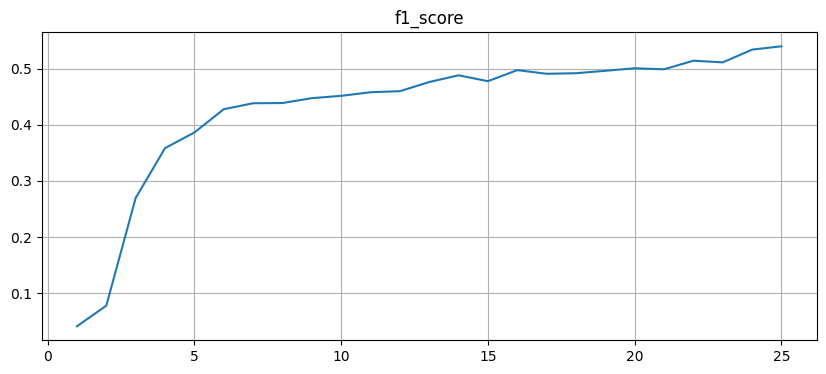

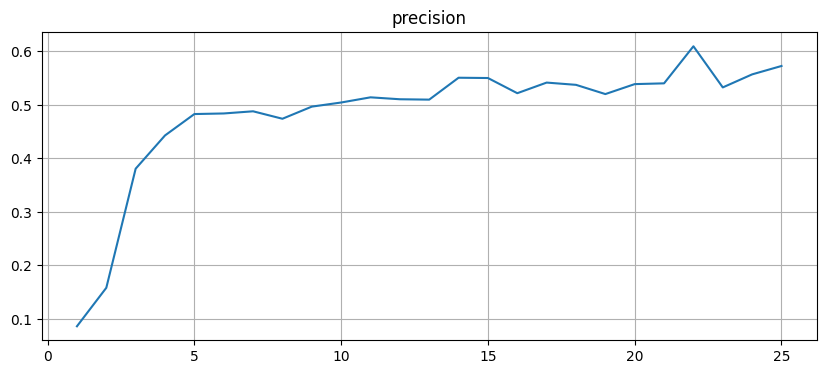

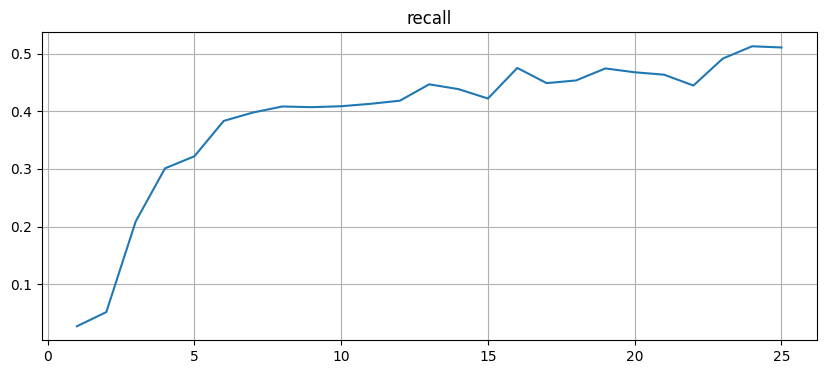

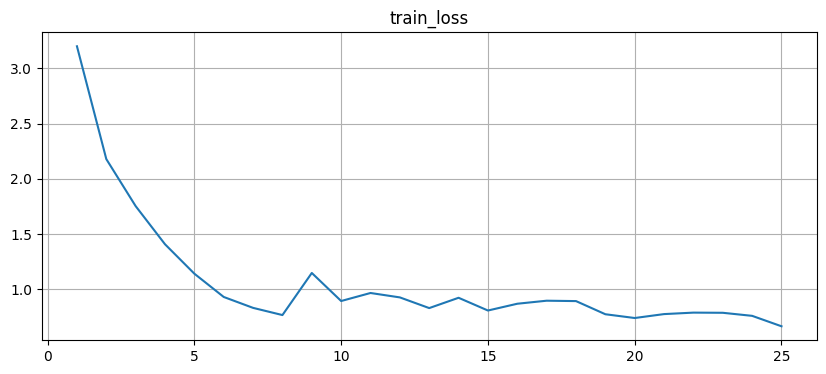

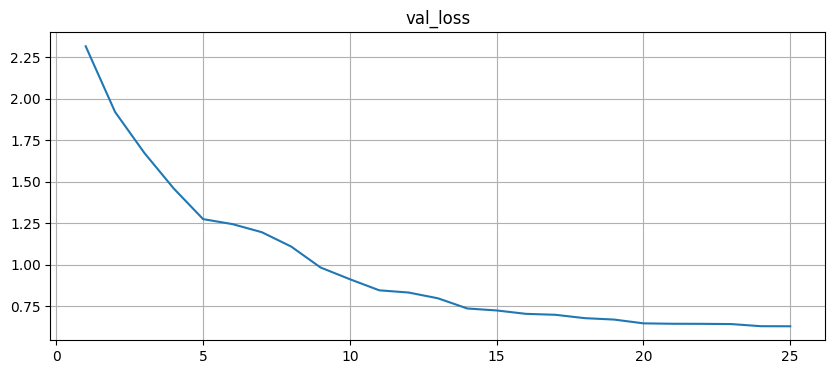

In [9]:
for i, (name, history) in enumerate (sorted (metrics.items ())):
    #plt.plot (1, len (metrics), i + 1)
    plt.figure (figsize = (10, 4))
    plt.title (name)
    plt.plot (*zip (*history))
    plt.grid ()
    plt.show ()

In [10]:


model.eval ()  # Устанавливаем модель в режим оценки
val_preds, val_labels_fromdata = [], []

with torch.no_grad ():
    for batch in tqdm (val_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask)

        val_preds.extend (out)
        val_labels_fromdata.extend (labels)
        torch.cuda.empty_cache ()

    print ('Validation: ', sanity_check (val_preds, val_labels_fromdata))


val_preds, val_labels_fromdata = [], []

with torch.no_grad ():
    for batch in tqdm (test_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask)

        val_preds.extend (out)
        val_labels_fromdata.extend (labels)
        torch.cuda.empty_cache ()

    print ('Test: ', sanity_check (val_preds, val_labels_fromdata))


100%|██████████| 25/25 [00:11<00:00,  2.23it/s]


Validation:  (0.5140664961636828, 0.33612040133779264, 0.40647118301314455)


100%|██████████| 29/29 [00:12<00:00,  2.32it/s]


Test:  (0.5286908077994429, 0.3615238095238095, 0.4294117647058824)


In [11]:

val_preds, val_labels_fromdata = [], []
with torch.no_grad ():
    for batch in tqdm (val_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        val_preds.extend (out)
        val_labels_fromdata.extend (labels)
        torch.cuda.empty_cache ()

    print ('Validation wmax: ', sanity_check (val_preds, val_labels_fromdata))

val_preds, val_labels_fromdata = [], []
with torch.no_grad ():
    for batch in tqdm (test_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        val_preds.extend (out)
        val_labels_fromdata.extend (labels)
        torch.cuda.empty_cache ()

    print ('Test wmax: ', sanity_check (val_preds, val_labels_fromdata))


100%|██████████| 25/25 [01:12<00:00,  2.88s/it]


Validation wmax:  (0.5729020159399906, 0.5108695652173914, 0.5401104972375691)


100%|██████████| 29/29 [01:00<00:00,  2.10s/it]


Test wmax:  (0.5843828715365239, 0.5302857142857142, 0.5560215698022768)


In [12]:
#model.save_pretrained ('./rut5base_fulltrain_novalid_dictionary_postfix')
#tokenizer.save_pretrained ('./rut5base_fulltrain_novalid_dictionary_postfix')

In [13]:
'''

Validation wmax:  (0.6070240295748613, 0.6864548494983278, 0.6443005689621345)
Test wmax:  (0.6368438428524266, 0.7348571428571429, 0.6823487796250443)

'''

'\n\nValidation wmax:  (0.6070240295748613, 0.6864548494983278, 0.6443005689621345)\nTest wmax:  (0.6368438428524266, 0.7348571428571429, 0.6823487796250443)\n\n'

In [14]:
print (val_parallel_text [6])
predicted_set = get_set (val_preds [6], ground_truth = False)
predicted_set

Такие сети отображаются на XML-файлы, которые служат для организации Баз Знаний, соответствующих семантических поисков, для решения логико-аналитических задач, а также для автоматического заполнения реляционных БД.


{'базовой 3-граммной моделью',
 'интерполированных',
 'моделей',
 'моделью',
 'распознавания',
 'речи',
 'слитной русской речи',
 'словарем',
 'факторных моделей',
 'языка'}

In [15]:
#model.save_pretrained('./rut5small_fulltrain_dictpostfix_avg7209-7591')
#tokenizer.save_pretrained('./rut5small_fulltrain_dictpostfix_avg7209-7591')

In [16]:
print 5

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(...)? (1206750932.py, line 1)

In [ ]:
model = MT5ForConditionalGeneration.from_pretrained ('./coint_rut5small_finetune_fulltrain_novalid')

model.to (device)
print (model.device)

In [ ]:
val_preds, val_labels = [], []
with torch.no_grad ():
    for batch in tqdm (val_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        val_preds.extend (out)
        val_labels.extend (labels)
        torch.cuda.empty_cache ()

    print ('Validation augmented: ', sanity_check (val_preds, val_labels))

In [ ]:

parallel_text_val_augmented = []
for i in range (len (val_preds)):
    predicted_set = get_set (val_preds [i], ground_truth = False)
    parallel_text_val_augmented.append (make_attachment (val_parallel_text [i], predicted_set))

val_data = tokenizer (parallel_text_val_augmented, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
val_labels = tokenizer (val_parallel_labels, padding = 'max_length', truncation = True, max_length = ANSWER_MAX_LENGTH, return_tensors = 'pt')

if ENABLE_LABEL_FIX:
    rse = replace_padding (val_labels)
    val_labels = rse

val_dataset = Seq2SeqDataset (val_data, val_labels)

val_loader = DataLoader (val_dataset, batch_size = EVAL_BATCH_SIZE)

In [ ]:
prev_model = MT5ForConditionalGeneration.from_pretrained ('./coint_rut5small_finetune_fulltrain_novalid')

prev_model.to (device)
print (prev_model.device)

In [ ]:

val_data = tokenizer (parallel_text_val, padding = 'max_length', truncation = True, max_length = 150, return_tensors = 'pt')
val_labels = tokenizer (parallel_label_val, padding = 'max_length', truncation = True, max_length = 150, return_tensors = 'pt')

if ENABLE_LABEL_FIX:
    rse = replace_padding (val_labels)
    val_labels = rse

val_dataset = Seq2SeqDataset (val_data, val_labels)

val_loader = DataLoader (val_dataset, batch_size = EVAL_BATCH_SIZE)

In [ ]:
val_preds, val_labels = [], []
with torch.no_grad ():
    for batch in tqdm (val_loader):
        input_ids = batch ['input_ids'].to (prev_model.device)
        attention_mask = batch ['attention_mask'].to (prev_model.device)
        labels = batch ['labels'].to (prev_model.device)
        out = prev_model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        val_preds.extend (out)
        val_labels.extend (labels)
        torch.cuda.empty_cache ()

    print ('Validation augmented: ', sanity_check (val_preds, val_labels))

In [ ]:
#model.save_pretrained('./rut5small_fulltrain_novalid_dictionary_postfix')
#tokenizer.save_pretrained('./rut5small_fulltrain_novalid_dictionary_postfix')